A very simple contextual bandit example with 3 arms

In [12]:
import gym
from gym.spaces import Discrete, Box
import numpy as np
import random
from ray import tune
import time
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
class SimpleContextualBandit (gym.Env):
    def __init__ (self, config=None):
        self.action_space = Discrete(3)
        self.observation_space = Box(low=-1., high=1., shape=(2, ))
        self.cur_context = None

    def reset (self):
        self.cur_context = random.choice([-1., 1.])
        return np.array([self.cur_context, -self.cur_context])

    def step (self, action):
        rewards_for_context = {
            -1.: [-10, 0, 10],
            1.: [10, 0, -10],
        }
        
        reward = rewards_for_context[self.cur_context][action]
        
        return (np.array([-self.cur_context, self.cur_context]), reward, True,
                {
                    "regret": 10 - reward
                })

In [6]:
stop = {
    "training_iteration": 200,
    "timesteps_total": 100000,
    "episode_reward_mean": 10.0,
}

config = {
    "env": SimpleContextualBandit,
}

In [10]:
start_time = time.time()

analysis = tune.run("contrib/LinUCB", config=config, stop=stop)

print("The trials took", time.time() - start_time, "seconds\n")

Trial name,status,loc
contrib_LinUCB_SimpleContextualBandit_00000,RUNNING,


(pid=95819) 2020-05-18 14:01:59,270	INFO trainer.py:421 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
(pid=95819) 2020-05-18 14:01:59,273	INFO trainer.py:580 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=95819) /opt/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=95819)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=95819) 2020-05-18 14:01:59,280	INFO trainable.py:217 -- Getting current IP.
(pid=95819) 2020-05-18 14:01:59,280	WARNING util.py:37 -- Install gputil for GPU system monitoring.
Result for contrib_LinUCB_SimpleContextualBandit_00000:
  custom_metrics: {}
  date: 2020-05-18_14-01-59
  done: false
  episode_len_mean: 1.0
  episode_reward_max: 10.0
  episode_reward_mean: 9.9
  episode_reward_min: 0.0
  episodes_this_iter: 100
  episodes_total: 100
  experiment_id: 

Trial name,status,loc,iter,total time (s),ts,reward
contrib_LinUCB_SimpleContextualBandit_00000,TERMINATED,,2,0.264121,200,10


The trials took 3.668159008026123 seconds



In [14]:
df = pd.DataFrame()

for key, df_trial in analysis.trial_dataframes.items():
    df = df.append(df_trial, ignore_index=True)

regrets = df \
    .groupby("num_steps_trained")["learner/cumulative_regret"] \
    .aggregate(["mean", "max", "min", "std"])

Text(0.5, 0, 'Training steps')

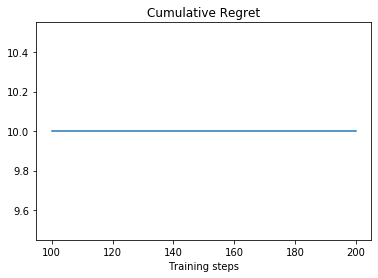

In [15]:
fig, ax = plt.subplots()

ax.plot(regrets["mean"])
ax.set_title("Cumulative Regret")
ax.set_xlabel("Training steps")